In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.cluster import MiniBatchKMeans, SpectralCoclustering
from sklearn.metrics import adjusted_rand_score

from skimage.morphology import closing, disk, square
from tools import *

In [2]:
indiana_img = np.load('../data/indianapines.npy')
indiana_labels = np.load('../data/indianapines_gt.npy')
salinas_img = np.load('../data/salinas.npy')
salinas_labels = np.load('../data/salinas_gt.npy')

In [3]:
# normalize radiance values to get reflectance values
indiana_img = indiana_img / indiana_img.max()
salinas_img = salinas_img / salinas_img.max()

In [4]:
print("Indiana shape: {}".format(indiana_img.shape))
print("Salinas shape: {}".format(salinas_img.shape))

Indiana shape: (145, 145, 200)
Salinas shape: (512, 217, 204)


In [5]:
X_indiana = indiana_img.reshape((-1, indiana_img.shape[-1])) # reshaping the HSI as a 2D matrix
print("Indiana shape: {}".format(X_indiana.shape))

X_salinas = salinas_img.reshape((-1, salinas_img.shape[-1])) # reshaping the HSI as a 2D matrix
print("Salinas shape: {}".format(X_salinas.shape))

Indiana shape: (21025, 200)
Salinas shape: (111104, 204)


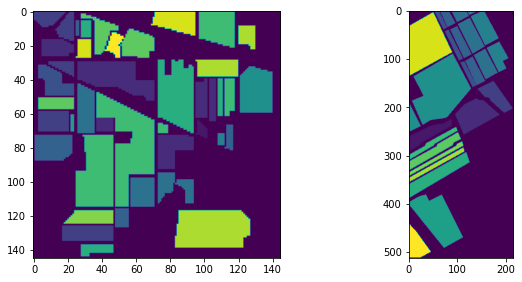

In [6]:
plot_two_figures(indiana_labels, salinas_labels, '', '')

In [7]:
n_components_indiana = get_number_components(X_indiana)
n_components_salinas = get_number_components(X_salinas)

Fitting the PCA
Fitting the PCA


In [8]:
print("Number of components Indiana: {}".format(n_components_indiana))
print("Number of components Salinas: {}".format(n_components_salinas))

Number of components Indiana: 69
Number of components Salinas: 6


In [9]:
X_indiana_reduced = extract_features(X_indiana, n_components_indiana)
X_salinas_reduced = extract_features(X_salinas, n_components_salinas)

In [10]:
print("Indiana reduced data shape: {}".format(X_indiana_reduced.shape))
print("Salinas reduced data shape: {}".format(X_salinas_reduced.shape))

Indiana reduced data shape: (21025, 69)
Salinas reduced data shape: (111104, 6)


### RX anomaly detector

In [11]:
c = np.cov(X_salinas_reduced.T)
inv_c = np.linalg.inv(c)

res = np.empty((X_salinas_reduced.shape))

for i in range(res.shape[0]):
    res[i] = X_salinas_reduced[i] @ inv_c @ X_salinas_reduced[i]
    
res = np.abs(res)

### Display

In [12]:
anomalies = res.reshape((salinas_img.shape[0], salinas_img.shape[1], 6))
X_reduced_img = X_salinas_reduced.reshape((salinas_img.shape[0], salinas_img.shape[1], 6))

In [13]:
anomalies_res = anomalies[:, :, 1] > 50

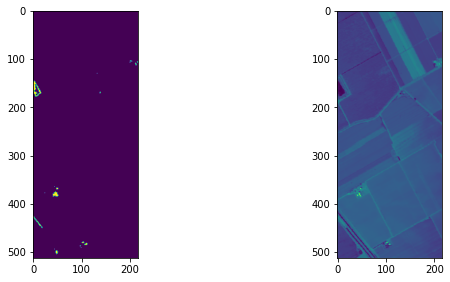

In [14]:
plot_two_figures(anomalies_res, X_reduced_img[:, :, 1], '', '')

In [15]:
outlier_pos = np.argwhere(anomalies_res == True).tolist()

In [16]:
X_no_outlier, X_positions = copy_without_outlier(X_reduced_img, outlier_pos)

In [17]:
print(X_no_outlier.shape)
print(X_reduced_img.shape)
print(len(outlier_pos))

(110638, 6)
(512, 217, 6)
466


### SpectralCoClustering

In [18]:
n_cluster_indiana = len(np.unique(indiana_labels)) - 1
n_cluster_salinas = len(np.unique(salinas_labels)) - 1

In [19]:
print("Number of labels Indiana: {}".format(n_cluster_indiana))
print("Number of labels Salinas: {}".format(n_cluster_salinas))

Number of labels Indiana: 16
Number of labels Salinas: 16


In [20]:
model = SpectralCoclustering(n_clusters=n_cluster_salinas)

In [21]:
model.fit(X_no_outlier)

SpectralCoclustering(n_clusters=16)

In [23]:
preds = model.row_labels_

In [25]:
preds.shape

(110638,)

In [26]:
preds = rebuild_data_with_outliers(preds, X_positions, outlier_pos, (salinas_img.shape[0], salinas_img.shape[1]))

In [27]:
preds.shape

(512, 217)

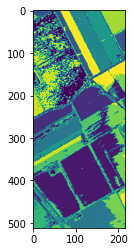

In [28]:
plt.imshow(preds)

In [29]:
final_salinas_preds = remove_unclassified(preds, salinas_labels)

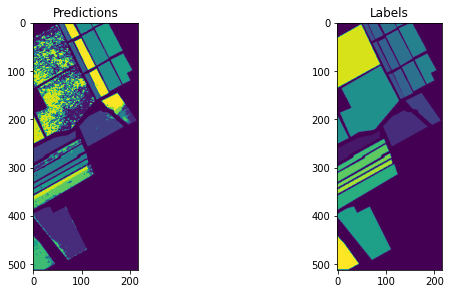

In [30]:
plot_two_figures(final_salinas_preds, salinas_labels, 'Predictions', 'Labels')